branch and push test

this branch is a test to see how branches work 

In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from itertools import combinations
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import coint
from hurst import compute_Hc
from statistics import mean
from random import sample

In [ ]:
# This class computes the beta (hedge ratio), spread, normalized spread,
# cointegration p-value, and Hurst exponent for a given pair of stocks.
# It does not generate signals or simulate trades; it just prepares statistical foundations.

class TimeSeriesPair:
    def __init__(self, stockX, stockY):
        self.name = f"{stockX.name}, {stockY.name}"
        self.stockX = stockX
        self.stockY = stockY
        self.beta = self._compute_beta()  # hedge ratio
        self.spread = self.stockY - self.beta * self.stockX  # spread time series
        self.normalized_spread = (self.spread - self.spread.mean()) / self.spread.std()  # z-score of spread
        self.p_value = self._compute_cointegration()  # test for cointegration
        self.hurst = self._compute_hurst()  # test for mean reversion

    def _compute_beta(self):
        # Convert Series to NumPy arrays to avoid indexing issues
        return OLS(self.stockY.values, self.stockX.values).fit().params[0]

    def _compute_cointegration(self):
        # Engle-Granger test: lower p-value implies stronger cointegration
        return coint(self.stockX, self.stockY)[1]

    def _compute_hurst(self):
        # Hurst exponent < 0.5 => mean-reverting
        return compute_Hc(self.spread)[0]

In [ ]:
# This class examines the normalized spread and determines entry, exit, and stop-loss points
# by detecting threshold crossings (e.g., z-score crossing +1 or -2, etc.).

class SignalGenerator:
    def __init__(self, series):
        self.series = series

    def _level_crosses(self, level):
        # Detect when the series crosses a level from the opposite side
        return [(1 if s > level and self.series.iloc[i - 1] < level else
                 -1 if s < level and self.series.iloc[i - 1] > level else 0)
                if i != 0 else 0 for i, s in enumerate(self.series)]

    def generate(self, entry_bound, exit_level, stop_level):
        # Generate entry, exit, and stop-loss signals using level crossings
        return {
            'upper_trading': pd.Series(self._level_crosses(entry_bound), index=self.series.index).shift(1),
            'lower_trading': pd.Series(self._level_crosses(-entry_bound), index=self.series.index).shift(1),
            'upper_stop': pd.Series(self._level_crosses(stop_level), index=self.series.index).shift(1),
            'lower_stop': pd.Series(self._level_crosses(-stop_level), index=self.series.index).shift(1),
            'mean': pd.Series(self._level_crosses(exit_level), index=self.series.index).shift(1)
        }

In [ ]:
# Given price data and trade signals, this class simulates pair trades:
# - Enters a trade on signal
# - Tracks returns, stop losses, and closed positions
# - Applies a simple position sizing model

class TradeSimulator:
    def __init__(self, spread, stockX, stockY, signals, 
                 trading_bound, stop_loss, exit_profit,
                 return_on_both_legs=False, waiting_period=30, tc=0.5):

        self.spread = spread
        self.stockX = stockX
        self.stockY = stockY
        self.signals = signals
        self.trading_bound = trading_bound
        self.stop_loss = stop_loss
        self.exit_profit = exit_profit
        self.return_on_both_legs = return_on_both_legs
        self.waiting_period = waiting_period
        self.tc = tc  # transaction cost as a percentage

        # Storage for open/closed positions
        self.open_positions = []
        self.closed_positions = []
        self.stop_losses = []

        # Run the backtest upon initialization
        self._simulate()

    def _calculate_returns(self, i):
        # Computes return from the current position at index i
        px, py = self.pos_x, self.pos_y
        sx, sy = self.stockX.iloc[i], self.stockY.iloc[i]
        cost_long = px[0] * px[1] if px[2] == 'l' else py[0] * py[1]
        profit = ((sx - px[0]) if px[2] == 'l' else (px[0] - sx)) * px[1] + \
                 ((py[0] - sy) if py[2] == 's' else (sy - py[0])) * py[1]

        if self.return_on_both_legs:
            total_cost = px[0] * px[1] + py[0] * py[1]
            gross_return = profit / total_cost * 100
        else:
            gross_return = profit / cost_long * 100

        return gross_return - (self.tc / 100) * gross_return

    def _simulate(self):
        # Main backtest loop: apply logic and simulate trades
        returns = []
        open_position = False
        i = 0
        sig = self.signals

        while i < len(self.spread):
            if open_position:
                # Check for stop-loss or profit exit
                if sig['upper_stop'].iloc[i] == 1 or sig['lower_stop'].iloc[i] == -1:
                    open_position = False
                    returns.append(self._calculate_returns(i))
                    self.stop_losses.append(i)
                    i += self.waiting_period
                    returns.extend([0] * (self.waiting_period - 1))
                    continue
                elif sig['mean'].iloc[i] != 0:
                    open_position = False
                    returns.append(self._calculate_returns(i))
                    self.closed_positions.append(i)
                else:
                    returns.append(0)
            else:
                # Open new trade
                if sig['upper_trading'].iloc[i] == -1 or sig['lower_trading'].iloc[i] == 1:
                    open_position = True
                    self.open_positions.append(i)
                    x, y = self.stockX.iloc[i], self.stockY.iloc[i]
                    b = y / x
                    a = 100000 / (y + b * x)  # approximate $100K exposure
                    num_y, num_x = math.ceil(a), math.ceil(a * b)
                    if sig['upper_trading'].iloc[i] == -1:
                        self.pos_x, self.pos_y = (x, num_x, 'l'), (y, num_y, 's')
                    else:
                        self.pos_x, self.pos_y = (x, num_x, 's'), (y, num_y, 'l')
                returns.append(0)
            i += 1

        # Ensure returns list is the same length as the price index
        returns = returns[:len(self.stockX)]

        self.returns_series = pd.Series(index=self.stockX.index, data=returns)
        self.cum_returns = self.returns_series.cumsum()
        self.profitable_trades_perc = len(self.closed_positions) / max(len(self.closed_positions) + len(self.stop_losses), 1) * 100

In [ ]:
# This class bundles the TimeSeriesPair, SignalGenerator, and TradeSimulator into a reusable unit.
# It also evaluates whether the pair is eligible for trading.

class PairStrategy:
    def __init__(self, stockX, stockY, **kwargs):
        self.name = f"{stockX.name}, {stockY.name}"
        self.pair = TimeSeriesPair(stockX, stockY)
        self.signals = SignalGenerator(self.pair.normalized_spread).generate(
            kwargs.get('trading_bound', 1),
            kwargs.get('exit_profit', 0),
            kwargs.get('stop_loss', 2)
        )
        self.sim = TradeSimulator(
            self.pair.normalized_spread, 
            self.pair.stockX, self.pair.stockY,
            self.signals,
            kwargs.get('trading_bound', 1),
            kwargs.get('stop_loss', 2),
            kwargs.get('exit_profit', 0),
            kwargs.get('return_on_both_legs', False),
            kwargs.get('waiting_period', 30),
            kwargs.get('tc', 0)
        )

    def eligible(self, p_thresh=0.05, h_thresh=0.5, min_crosses=12):
        mean_crosses = (self.signals['mean'] == 1).sum() + (self.signals['mean'] == -1).sum()
        return self.pair.p_value <= p_thresh and self.pair.hurst <= h_thresh and mean_crosses >= min_crosses

    def __repr__(self):
        return (f"PairStrategy [{self.name}]\n"
                f"\tp-value: {self.pair.p_value:.4f}\n"
                f"\tHurst: {self.pair.hurst:.4f}\n"
                f"\tProfitable Trades (%): {self.sim.profitable_trades_perc:.2f}\n"
                f"\tEligible: {self.eligible()}")


In [ ]:
# The Portfolio class loops through combinations of pairs, checks their eligibility,
# and aggregates their return streams into a single portfolio return curve.

class Portfolio:
    def __init__(self, df):
        self.df = df.dropna()
        self.symbols = self.df.columns
        self.selected_pairs = []

        for s1, s2 in combinations(self.symbols, 2):
            strategy = PairStrategy(self.df[s1], self.df[s2])
            if strategy.eligible():
                self.selected_pairs.append(strategy)

        self.calculate_portfolio_return()

    def calculate_portfolio_return(self):
        returns_dict = {pair.name: pair.sim.returns_series for pair in self.selected_pairs}
        df_return = pd.DataFrame(data=returns_dict)
        df_return['Return'] = df_return.mean(axis=1)  # equally weighted portfolio
        df_return['Cumulative Return'] = df_return['Return'].cumsum()
        self.cum_return = df_return['Cumulative Return']

    def plot_portfolio(self):
        plt.title(f"Portfolio Return ({len(self.selected_pairs)} Pairs)")
        plt.plot(self.cum_return)
        plt.ylabel("Cumulative Return (%)")
        plt.show()

In [ ]:
import os
import pandas as pd
import yfinance as yf
from datetime import datetime

# Download or Load Cached S&P 500 Data

def get_sp500_tickers():
    """Scrape S&P 500 ticker list from Wikipedia."""
    url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
    df = pd.read_html(url, header=0).iloc[0]
    tickers = df['Symbol'].tolist()
    # Fix special cases (e.g., BRK.B → BRK-B for yfinance)
    tickers = [t.replace('.', '-') for t in tickers]
    return tickers

def download_price_data(tickers, start="2020-01-01", end="2024-12-31"):
    """Download daily close prices using yfinance."""
    print(f"Downloading data for {len(tickers)} tickers...")
    df = yf.download(tickers, start=start, end=end)["Close"]
    print("Download complete.")
    return df.dropna(axis=1)

def load_or_download_data(filepath="sp500_data.pkl"):
    """Load from local cache if it exists, else download and save."""
    if os.path.exists(filepath):
        print("Loading cached data...")
        return pd.read_pickle(filepath)
    else:
        tickers = get_sp500_tickers()
        df = download_price_data(tickers)
        df.sort_index(inplace=True)
        df.to_pickle(filepath)
        print(f"Data saved to {filepath}")
        return df



Loading cached data...


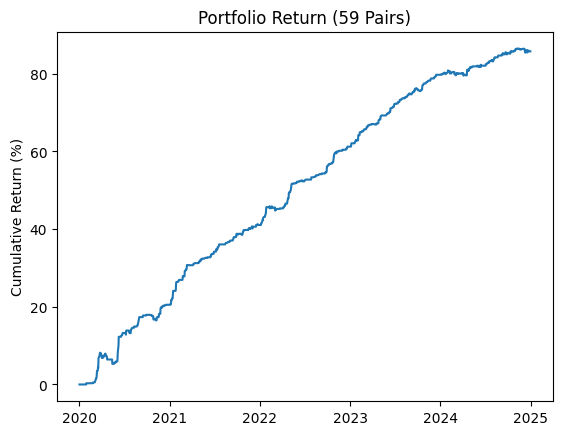

PairStrategy [WST, ZTS]
	p-value: 0.0131
	Hurst: 0.4614
	Profitable Trades (%): 100.00
	Eligible: True
PairStrategy [EIX, HPE]
	p-value: 0.0171
	Hurst: 0.4068
	Profitable Trades (%): 66.67
	Eligible: True
PairStrategy [BRO, AXP]
	p-value: 0.0440
	Hurst: 0.3695
	Profitable Trades (%): 82.35
	Eligible: True
PairStrategy [BRO, HPE]
	p-value: 0.0153
	Hurst: 0.4346
	Profitable Trades (%): 80.00
	Eligible: True
PairStrategy [PPL, V]
	p-value: 0.0111
	Hurst: 0.4477
	Profitable Trades (%): 87.50
	Eligible: True
PairStrategy [PPL, BF-B]
	p-value: 0.0086
	Hurst: 0.4887
	Profitable Trades (%): 50.00
	Eligible: True
PairStrategy [PPL, PAYX]
	p-value: 0.0193
	Hurst: 0.4977
	Profitable Trades (%): 100.00
	Eligible: True
PairStrategy [PPL, UAL]
	p-value: 0.0467
	Hurst: 0.4656
	Profitable Trades (%): 100.00
	Eligible: True
PairStrategy [PPL, HPE]
	p-value: 0.0031
	Hurst: 0.4741
	Profitable Trades (%): 50.00
	Eligible: True
PairStrategy [PPL, KIM]
	p-value: 0.0499
	Hurst: 0.4886
	Profitable Trades (%):

In [ ]:
# Run the Strategy

def df_generate_stocks_list(df, l=20):
    """
    Randomly select `l` columns (tickers) from the given DataFrame `df`.
    Returns a subset DataFrame with only those columns.
    """
    return df[sample(list(df.columns), l)]

if __name__ == "__main__":
    # Load cached or downloaded S&P 500 data
    df = load_or_download_data()

    # Randomly select a subset (adjust 'l' as needed)
    df_selected = df_generate_stocks_list(df, l=50)

    # Build and test the portfolio
    portfolio = Portfolio(df_selected)
    portfolio.plot_portfolio()

    # Print details of each pair
    for pair in portfolio.selected_pairs:
        print(pair)

    # Save results if desired
    portfolio.cum_return.to_csv("sp500_portfolio_returns.csv")